In [1]:
# Cell 0: Install Dependencies
import sys
import importlib.util

# Ensure snntorch is installed for the SNN training part
required_library = 'snntorch'
print(f"--- Checking for {required_library} ---")
if importlib.util.find_spec(required_library) is None:
    print(f"Installing {required_library}...")
    !{sys.executable} -m pip install --quiet {required_library}
    print(f"✅ {required_library} installed.")
else:
    print(f"✅ {required_library} is already installed.")

--- Checking for snntorch ---
Installing snntorch...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 2.8 MB/s eta 0:00:0000:01
✅ snntorch installed.


In [2]:
# Cell 1: Imports and Configuration
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import snntorch as snn
from snntorch import surrogate

# --- Configuration ---
# --- CHANGE THESE to match your dataset names on Kaggle ---
mitbih_dataset_name = "balanced-ecg-data-for-cardiac-arrest-prediction"
ptbxl_dataset_name = "ptb-xl-processed-ecg-beats"
# ---------------------------------------------------------

# Input paths
MITBIH_DIR = f"/kaggle/input/{mitbih_dataset_name}/processed_data_balanced"
PTBXL_DIR = f"/kaggle/input/{ptbxl_dataset_name}/ptbxl_processed_local"

# Output path
OUTPUT_DIR = "/kaggle/working/final_robust_models/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hardware and Training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# We'll use more epochs as the dataset is larger and more complex
CNN_EPOCHS = 20
SNN_EPOCHS = 10
BATCH_SIZE = 128

Using device: cuda


In [3]:
# Cell 2: Unified Data Loading and Preparation

print("--- Loading and Combining Datasets ---")

# Load MIT-BIH Data (using the original, non-augmented training set)
X_train_mitbih = np.load(os.path.join(MITBIH_DIR, "X_train.npy"))[:43744]
y_train_mitbih = np.load(os.path.join(MITBIH_DIR, "y_train.npy"))[:43744]
X_test_mitbih = np.load(os.path.join(MITBIH_DIR, "X_test.npy"))
y_test_mitbih = np.load(os.path.join(MITBIH_DIR, "y_test.npy"))
print(f"Loaded {len(y_train_mitbih) + len(y_test_mitbih)} beats from MIT-BIH.")

# Load PTB-XL Data
X_train_ptbxl = np.load(os.path.join(PTBXL_DIR, "X_train.npy"))
y_train_ptbxl = np.load(os.path.join(PTBXL_DIR, "y_train.npy"))
X_test_ptbxl = np.load(os.path.join(PTBXL_DIR, "X_test.npy"))
y_test_ptbxl = np.load(os.path.join(PTBXL_DIR, "y_test.npy"))
print(f"Loaded {len(y_train_ptbxl) + len(y_test_ptbxl)} beats from PTB-XL.")

# Combine into final training and testing sets
X_train = np.vstack([X_train_mitbih, X_train_ptbxl])
y_train = np.hstack([y_train_mitbih, y_train_ptbxl])
X_test = np.vstack([X_test_mitbih, X_test_ptbxl])
y_test = np.hstack([y_test_mitbih, y_test_ptbxl])

# Shuffle the training data to mix the datasets
shuffle_idx = np.random.permutation(len(y_train))
X_train, y_train = X_train[shuffle_idx], y_train[shuffle_idx]

print("\n--- Final Unified Dataset Summary ---")
print(f"Total Training Beats: {len(y_train)}")
print(f"Total Testing Beats:  {len(y_test)}")
u_train, c_train = np.unique(y_train, return_counts=True)
u_test, c_test = np.unique(y_test, return_counts=True)
print(f"Training set distribution:   {dict(zip(u_train, c_train))}")
print(f"Testing set distribution:    {dict(zip(u_test, c_test))}")

--- Loading and Combining Datasets ---
Loaded 54680 beats from MIT-BIH.
Loaded 250948 beats from PTB-XL.

--- Final Unified Dataset Summary ---
Total Training Beats: 244502
Total Testing Beats:  61126
Training set distribution:   {0: 114712, 1: 129790}
Testing set distribution:    {0: 28679, 1: 32447}


In [ ]:
# Cell 3: CNN Training on Unified Dataset (Fully Corrected)

# --- ADDED IMPORTS to make the cell self-contained ---
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim  # <-- The missing import is added here
from tqdm.notebook import tqdm
# ----------------------------------------------------

# --- Model and Dataset Definitions ---
class ECG_CNN(nn.Module):
    def __init__(self, input_length=187):
        super().__init__()
        self.conv1=nn.Conv1d(1,32,5,padding=2); self.relu1=nn.ReLU(); self.pool1=nn.MaxPool1d(3,2)
        self.conv2=nn.Conv1d(32,64,5,padding=2); self.relu2=nn.ReLU(); self.pool2=nn.MaxPool1d(3,2)
        self._to_linear=None; self._get_to_linear_size(input_length)
        self.fc1=nn.Linear(self._to_linear,128); self.relu3=nn.ReLU()
        self.dropout=nn.Dropout(0.5); self.fc2=nn.Linear(128,2)
    def _get_to_linear_size(self, l_in):
        with torch.no_grad():
            x=torch.zeros(1,1,l_in); x=self.pool1(self.relu1(self.conv1(x))); x=self.pool2(self.relu2(self.conv2(x))); self._to_linear=x.shape[1]*x.shape[2]
    def forward(self, x):
        x=self.pool1(self.relu1(self.conv1(x))); x=self.pool2(self.relu2(self.conv2(x)))
        x=x.view(-1,self._to_linear); x=self.relu3(self.fc1(x)); x=self.dropout(x); x=self.fc2(x); return x

class ECGDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = torch.tensor(signals, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self): return len(self.signals)
    def __getitem__(self, idx): return self.signals[idx], self.labels[idx]

# Create DataLoaders
train_ds = ECGDataset(X_train, y_train)
test_ds = ECGDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# --- Training Loop ---
print("\n--- [A] Starting Final CNN Training ---")
model_cnn = ECG_CNN(input_length=X_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

for epoch in range(CNN_EPOCHS):
    model_cnn.train()
    running_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"CNN Epoch {epoch+1}/{CNN_EPOCHS}"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model_cnn(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {running_loss / len(train_loader):.4f}")

print("✅ Final CNN training complete.")

In [4]:
# --- New Cell: Retrain CNN with Focal Loss (Definitive Version) ---

# 1. Imports to make the cell fully self-contained
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix

# 2. Configuration variables for this training run
CNN_EPOCHS = 20
BATCH_SIZE = 128

# 3. Required Class Definitions
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * ce_loss
        if self.reduction == 'mean': return focal_loss.mean()
        elif self.reduction == 'sum': return focal_loss.sum()
        else: return focal_loss

class ECG_CNN(nn.Module):
    def __init__(self, input_length=187):
        super().__init__()
        self.conv1=nn.Conv1d(1,32,5,padding=2); self.relu1=nn.ReLU(); self.pool1=nn.MaxPool1d(3,2)
        self.conv2=nn.Conv1d(32,64,5,padding=2); self.relu2=nn.ReLU(); self.pool2=nn.MaxPool1d(3,2)
        self._to_linear=None; self._get_to_linear_size(input_length)
        self.fc1=nn.Linear(self._to_linear,128); self.relu3=nn.ReLU()
        self.dropout=nn.Dropout(0.5); self.fc2=nn.Linear(128,2)
    def _get_to_linear_size(self, l_in):
        with torch.no_grad():
            x=torch.zeros(1,1,l_in); x=self.pool1(self.relu1(self.conv1(x))); x=self.pool2(self.relu2(self.conv2(x))); self._to_linear=x.shape[1]*x.shape[2]
    def forward(self, x):
        x=self.pool1(self.relu1(self.conv1(x))); x=self.pool2(self.relu2(self.conv2(x)))
        x=x.view(-1,self._to_linear); x=self.relu3(self.fc1(x)); x=self.dropout(x); x=self.fc2(x); return x

class ECGDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = torch.tensor(signals, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self): return len(self.signals)
    def __getitem__(self, idx): return self.signals[idx], self.labels[idx]

# 4. Create DataLoaders (This was the missing part)
# This assumes 'X_train', 'y_train', 'X_test', 'y_test' are loaded from Cell 2
train_ds = ECGDataset(X_train, y_train)
test_ds = ECGDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
print("DataLoaders created successfully.")

# 5. Initialize a NEW CNN model and Training components
print("\n--- [A.2] Starting Final CNN Training with FOCAL LOSS ---")
model_cnn_focal = ECG_CNN(input_length=X_train.shape[1]).to(device)
criterion = FocalLoss(gamma=2.0)
optimizer = optim.Adam(model_cnn_focal.parameters(), lr=0.001)

# 6. Training Loop
for epoch in range(CNN_EPOCHS):
    model_cnn_focal.train()
    running_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"CNN Focal Loss Epoch {epoch+1}/{CNN_EPOCHS}"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model_cnn_focal(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {running_loss / len(train_loader):.4f}")
print("✅ Final CNN training with Focal Loss complete.")

# 7. Final Evaluation
model_cnn_focal.eval()
y_true_focal, y_pred_focal = [], []
with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Evaluating CNN with Focal Loss"):
        xb = xb.to(device)
        outputs = model_cnn_focal(xb)
        _, predicted = torch.max(outputs.data, 1)
        y_true_focal.extend(yb.numpy())
        y_pred_focal.extend(predicted.cpu().numpy())
print("\n--- FINAL CNN (FOCAL LOSS) PERFORMANCE REPORT ---")
print(classification_report(y_true_focal, y_pred_focal, target_names=['Normal (0)', 'Abnormal (1)']))
print("Confusion Matrix:\n", confusion_matrix(y_true_focal, y_pred_focal))

# 8. Save the new model
torch.save(model_cnn_focal.state_dict(), os.path.join(OUTPUT_DIR, 'final_robust_cnn_focal_loss.pt'))
print(f"\n✅ Final robust CNN (Focal Loss) model saved to {OUTPUT_DIR}")

DataLoaders created successfully.

--- [A.2] Starting Final CNN Training with FOCAL LOSS ---


CNN Focal Loss Epoch 1/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 1 Loss: 0.0264


CNN Focal Loss Epoch 2/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 2 Loss: 0.0237


CNN Focal Loss Epoch 3/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 3 Loss: 0.0228


CNN Focal Loss Epoch 4/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 4 Loss: 0.0222


CNN Focal Loss Epoch 5/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 5 Loss: 0.0218


CNN Focal Loss Epoch 6/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 6 Loss: 0.0215


CNN Focal Loss Epoch 7/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 7 Loss: 0.0211


CNN Focal Loss Epoch 8/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 8 Loss: 0.0209


CNN Focal Loss Epoch 9/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 9 Loss: 0.0206


CNN Focal Loss Epoch 10/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 10 Loss: 0.0204


CNN Focal Loss Epoch 11/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 11 Loss: 0.0202


CNN Focal Loss Epoch 12/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 12 Loss: 0.0200


CNN Focal Loss Epoch 13/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 13 Loss: 0.0198


CNN Focal Loss Epoch 14/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 14 Loss: 0.0196


CNN Focal Loss Epoch 15/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 15 Loss: 0.0195


CNN Focal Loss Epoch 16/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 16 Loss: 0.0192


CNN Focal Loss Epoch 17/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 17 Loss: 0.0190


CNN Focal Loss Epoch 18/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 18 Loss: 0.0189


CNN Focal Loss Epoch 19/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 19 Loss: 0.0187


CNN Focal Loss Epoch 20/20:   0%|          | 0/1911 [00:00<?, ?it/s]

Epoch 20 Loss: 0.0185
✅ Final CNN training with Focal Loss complete.


Evaluating CNN with Focal Loss:   0%|          | 0/478 [00:00<?, ?it/s]


--- FINAL CNN (FOCAL LOSS) PERFORMANCE REPORT ---
              precision    recall  f1-score   support

  Normal (0)       0.85      0.88      0.86     28679
Abnormal (1)       0.89      0.86      0.87     32447

    accuracy                           0.87     61126
   macro avg       0.87      0.87      0.87     61126
weighted avg       0.87      0.87      0.87     61126

Confusion Matrix:
 [[25146  3533]
 [ 4482 27965]]

✅ Final robust CNN (Focal Loss) model saved to /kaggle/working/final_robust_models/


In [ ]:
# --- Cell:3.2 Data Preparation for Sequential Models ---

from torch.utils.data import Dataset

# --- 1. Define the SequenceDataset Class ---
# This class takes our flat list of beats and turns it into sequences.
class SequenceDataset(Dataset):
    def __init__(self, signals, labels, sequence_length=10):
        self.signals = torch.tensor(signals, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.sequence_length = sequence_length

    def __len__(self):
        # The number of possible sequences is the total length minus the sequence length
        return self.signals.shape[0] - self.sequence_length + 1

    def __getitem__(self, idx):
        # The sequence of signals
        signal_sequence = self.signals[idx : idx + self.sequence_length]
        
        # We'll use the label of the LAST beat in the sequence as the target label
        # This is a common strategy for sequence classification.
        label = self.labels[idx + self.sequence_length - 1]
        
        # Add the channel dimension to each beat in the sequence
        return signal_sequence.unsqueeze(1), label

print("✅ SequenceDataset class defined.")

# --- Cell 3.2: The CNN+LSTM Hybrid Model Architecture ---

# --- 1. Define the CNN Feature Extractor ---
# This is the convolutional part from your proven ECG_CNN, acting as our "Expert Eye".
class CNNFeatureExtractor(nn.Module):
    def __init__(self, input_length=187):
        super().__init__()
        self.conv1=nn.Conv1d(1,32,5,padding=2); self.relu1=nn.ReLU(); self.pool1=nn.MaxPool1d(3,2)
        self.conv2=nn.Conv1d(32,64,5,padding=2); self.relu2=nn.ReLU(); self.pool2=nn.MaxPool1d(3,2)
        self._to_linear=None; self._get_to_linear_size(input_length)
        self.fc1=nn.Linear(self._to_linear,128); self.relu3=nn.ReLU()
    def _get_to_linear_size(self, l_in):
        with torch.no_grad():
            x=torch.zeros(1,1,l_in); x=self.pool1(self.relu1(self.conv1(x))); x=self.pool2(self.relu2(self.conv2(x))); self._to_linear=x.shape[1]*x.shape[2]
    def forward(self, x):
        x=self.pool1(self.relu1(self.conv1(x))); x=self.pool2(self.relu2(self.conv2(x)))
        x=x.view(-1,self._to_linear); embeddings=self.relu3(self.fc1(x)); return embeddings

# --- 2. Define the Full Hybrid CNN+LSTM Model ---
class CNN_LSTM_Model(nn.Module):
    def __init__(self, cnn_feature_extractor, lstm_hidden_size=128, lstm_layers=2):
        super().__init__()
        self.cnn = cnn_feature_extractor
        self.lstm = nn.LSTM(
            input_size=128, # Input feature size must match CNN embedding size
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True # This makes handling shapes much easier
        )
        self.fc = nn.Linear(lstm_hidden_size, 2) # Final classifier

    def forward(self, x):
        # x starts as (batch_size, sequence_length, channels, signal_length)
        # e.g., (64, 10, 1, 187)
        
        batch_size, seq_len, c, h = x.size()
        
        # Reshape to pass all beats through the CNN at once for efficiency
        # -> (batch_size * seq_len, channels, signal_length) e.g., (640, 1, 187)
        c_in = x.view(batch_size * seq_len, c, h)
        
        # Get embeddings from the CNN
        # -> (batch_size * seq_len, 128)
        c_out = self.cnn(c_in)
        
        # Reshape back into a sequence for the LSTM
        # -> (batch_size, seq_len, 128)
        r_in = c_out.view(batch_size, seq_len, -1)
        
        # Pass the sequence of embeddings through the LSTM
        # lstm_out shape: (batch_size, seq_len, lstm_hidden_size)
        lstm_out, _ = self.lstm(r_in)
        
        # We only need the output from the LAST time step for classification
        # -> (batch_size, lstm_hidden_size)
        last_time_step_out = lstm_out[:, -1, :]
        
        # Pass the final output through the classifier
        logits = self.fc(last_time_step_out)
        
        return logits

print("✅ CNN_LSTM_Model class defined.")

# --- New Cell: CNN+LSTM Training and Evaluation (Fully Corrected) ---

# --- ADDED IMPORTS to make the cell self-contained ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix
# ----------------------------------------------------

# --- 1. Configuration ---
SEQUENCE_LENGTH = 10
LSTM_EPOCHS = 20
BATCH_SIZE_LSTM = 64

# --- 2. Create the Sequence DataLoaders ---
# This assumes the SequenceDataset class was defined in the previous cell
train_seq_ds = SequenceDataset(X_train, y_train, sequence_length=SEQUENCE_LENGTH)
test_seq_ds = SequenceDataset(X_test, y_test, sequence_length=SEQUENCE_LENGTH)

train_seq_loader = DataLoader(train_seq_ds, batch_size=BATCH_SIZE_LSTM, shuffle=True)
test_seq_loader = DataLoader(test_seq_ds, batch_size=BATCH_SIZE_LSTM, shuffle=False)

# --- 3. Initialize the Model ---
# This assumes the CNNFeatureExtractor and CNN_LSTM_Model classes were defined in the previous cell
cnn_base = CNNFeatureExtractor(input_length=187)
model_cnn_lstm = CNN_LSTM_Model(cnn_base).to(device)

criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(model_cnn_lstm.parameters(), lr=1e-4) # Use a smaller learning rate

# --- 4. Training Loop ---
print(f"\n--- Starting Final CNN+LSTM Training (Sequence Length: {SEQUENCE_LENGTH}) ---")
for epoch in range(LSTM_EPOCHS):
    model_cnn_lstm.train()
    running_loss = 0.0
    for xb_seq, yb in tqdm(train_seq_loader, desc=f"CNN+LSTM Epoch {epoch+1}/{LSTM_EPOCHS}"):
        xb_seq, yb = xb_seq.to(device), yb.to(device)
        optimizer_lstm.zero_grad()
        outputs = model_cnn_lstm(xb_seq)
        loss = criterion_lstm(outputs, yb)
        loss.backward()
        optimizer_lstm.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {running_loss / len(train_seq_loader):.4f}")

print("✅ Final CNN+LSTM training complete.")

# --- 5. Final Evaluation ---
model_cnn_lstm.eval()
y_true_lstm, y_pred_lstm = [], []
with torch.no_grad():
    for xb_seq, yb in tqdm(test_seq_loader, desc="Evaluating CNN+LSTM"):
        xb_seq = xb_seq.to(device)
        outputs = model_cnn_lstm(xb_seq)
        _, predicted = torch.max(outputs.data, 1)
        y_true_lstm.extend(yb.numpy())
        y_pred_lstm.extend(predicted.cpu().numpy())

print("\n--- FINAL CNN+LSTM PERFORMANCE REPORT ---")
print(classification_report(y_true_lstm, y_pred_lstm, target_names=['Normal (0)', 'Abnormal (1)']))
print("Confusion Matrix:\n", confusion_matrix(y_true_lstm, y_pred_lstm))

# --- 6. Save the Final Model ---
torch.save(model_cnn_lstm.state_dict(), os.path.join(OUTPUT_DIR, 'final_robust_cnn_lstm.pt'))
print(f"\n✅ Final robust CNN+LSTM model saved to {OUTPUT_DIR}")

In [ ]:
# Cell 4: Evaluation of CNN and Fusion RF Model

print("\n--- [B] Evaluating Final Models ---")

# --- 1. Evaluate the CNN ---
model_cnn.eval()
y_true_cnn, y_pred_cnn, y_prob_cnn = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model_cnn(xb)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(probs, 1)
        y_true_cnn.extend(yb.numpy())
        y_pred_cnn.extend(predicted.cpu().numpy())
        y_prob_cnn.extend(probs.cpu().numpy())

print("\n--- FINAL CNN PERFORMANCE REPORT ---")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=['Normal (0)', 'Abnormal (1)']))
print("Confusion Matrix:\n", confusion_matrix(y_true_cnn, y_pred_cnn))

# --- 2. Train and Evaluate the RF-on-Embeddings Model ---
# (This part is omitted for now to focus on the SNN as requested next)
# The logic would be the same as in Step 4 if you wish to add it back.

# --- 3. Save Final CNN Model ---
torch.save(model_cnn.state_dict(), os.path.join(OUTPUT_DIR, 'final_robust_cnn.pt'))
print(f"\n✅ Final robust CNN model saved to {OUTPUT_DIR}")

In [ ]:
# Cell 5: SNN Training and Evaluation (Fully Corrected)

# --- ADDED IMPORTS to make the cell self-contained ---
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import snntorch as snn
from snntorch import surrogate
# ----------------------------------------------------

print("\n--- [C] Starting Final SNN Training ---")

# SNN Model Definition
class SNN_Model(nn.Module):
    def __init__(self, beta=0.95, spike_grad=surrogate.atan()):
        super().__init__()
        self.conv1=nn.Conv1d(1,32,5,padding=2); self.lif1=snn.Leaky(beta=beta,spike_grad=spike_grad)
        self.pool1=nn.MaxPool1d(3,2); self.conv2=nn.Conv1d(32,64,5,padding=2)
        self.lif2=snn.Leaky(beta=beta,spike_grad=spike_grad); self.pool2=nn.MaxPool1d(3,2)
        self._to_linear=64*46; self.fc1=nn.Linear(self._to_linear,128)
        self.lif3=snn.Leaky(beta=beta,spike_grad=spike_grad); self.fc2=nn.Linear(128,2)
        self.lif4=snn.Leaky(beta=beta,spike_grad=spike_grad)
    def forward(self, x):
        mem1=self.lif1.init_leaky(); mem2=self.lif2.init_leaky(); mem3=self.lif3.init_leaky(); mem4=self.lif4.init_leaky()
        mem4_rec=[]
        for step in range(50):
            cur1=self.pool1(self.conv1(x)); spk1,mem1=self.lif1(cur1,mem1); cur2=self.pool2(self.conv2(spk1))
            spk2,mem2=self.lif2(cur2,mem2); flat=spk2.view(x.size(0),-1); cur3=self.fc1(flat)
            spk3,mem3=self.lif3(cur3,mem3); cur4=self.fc2(spk3); spk4,mem4=self.lif4(cur4,mem4)
            mem4_rec.append(mem4)
        return torch.stack(mem4_rec,dim=0).sum(dim=0)

# Recreate DataLoaders just in case, using the globally defined X_train, y_train etc.
train_ds_snn = TensorDataset(torch.tensor(X_train, dtype=torch.float32).unsqueeze(1), torch.tensor(y_train, dtype=torch.long))
test_ds_snn = TensorDataset(torch.tensor(X_test, dtype=torch.float32).unsqueeze(1), torch.tensor(y_test, dtype=torch.long))
train_loader_snn = DataLoader(train_ds_snn, batch_size=BATCH_SIZE, shuffle=True)
test_loader_snn = DataLoader(test_ds_snn, batch_size=BATCH_SIZE, shuffle=False)
        
# --- Training Loop ---
model_snn = SNN_Model().to(device)
criterion_snn = nn.CrossEntropyLoss()
optimizer_snn = optim.Adam(model_snn.parameters(), lr=1e-3)

for epoch in range(SNN_EPOCHS):
    model_snn.train()
    running_loss = 0.0
    for xb, yb in tqdm(train_loader_snn, desc=f"SNN Epoch {epoch+1}/{SNN_EPOCHS}"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer_snn.zero_grad()
        outputs = model_snn(xb)
        loss = criterion_snn(outputs, yb)
        loss.backward()
        optimizer_snn.step()
        running_loss += loss.item()
    print(f"SNN Epoch {epoch+1} Loss: {running_loss / len(train_loader_snn):.4f}")
print("✅ Final SNN training complete.")

# --- Evaluation ---
model_snn.eval()
y_true_snn, y_pred_snn = [], []
with torch.no_grad():
    for xb, yb in tqdm(test_loader_snn, desc="Evaluating SNN"):
        xb = xb.to(device)
        outputs = model_snn(xb)
        _, predicted = torch.max(outputs.data, 1)
        y_true_snn.extend(yb.numpy())
        y_pred_snn.extend(predicted.cpu().numpy())

print("\n--- FINAL SNN PERFORMANCE REPORT ---")
print(classification_report(y_true_snn, y_pred_snn, target_names=['Normal (0)', 'Abnormal (1)']))
print("Confusion Matrix:\n", confusion_matrix(y_true_snn, y_pred_snn))

# --- Save Final SNN Model ---
torch.save(model_snn.state_dict(), os.path.join(OUTPUT_DIR, 'final_robust_snn.pt'))
print(f"\n✅ Final robust SNN model saved to {OUTPUT_DIR}")

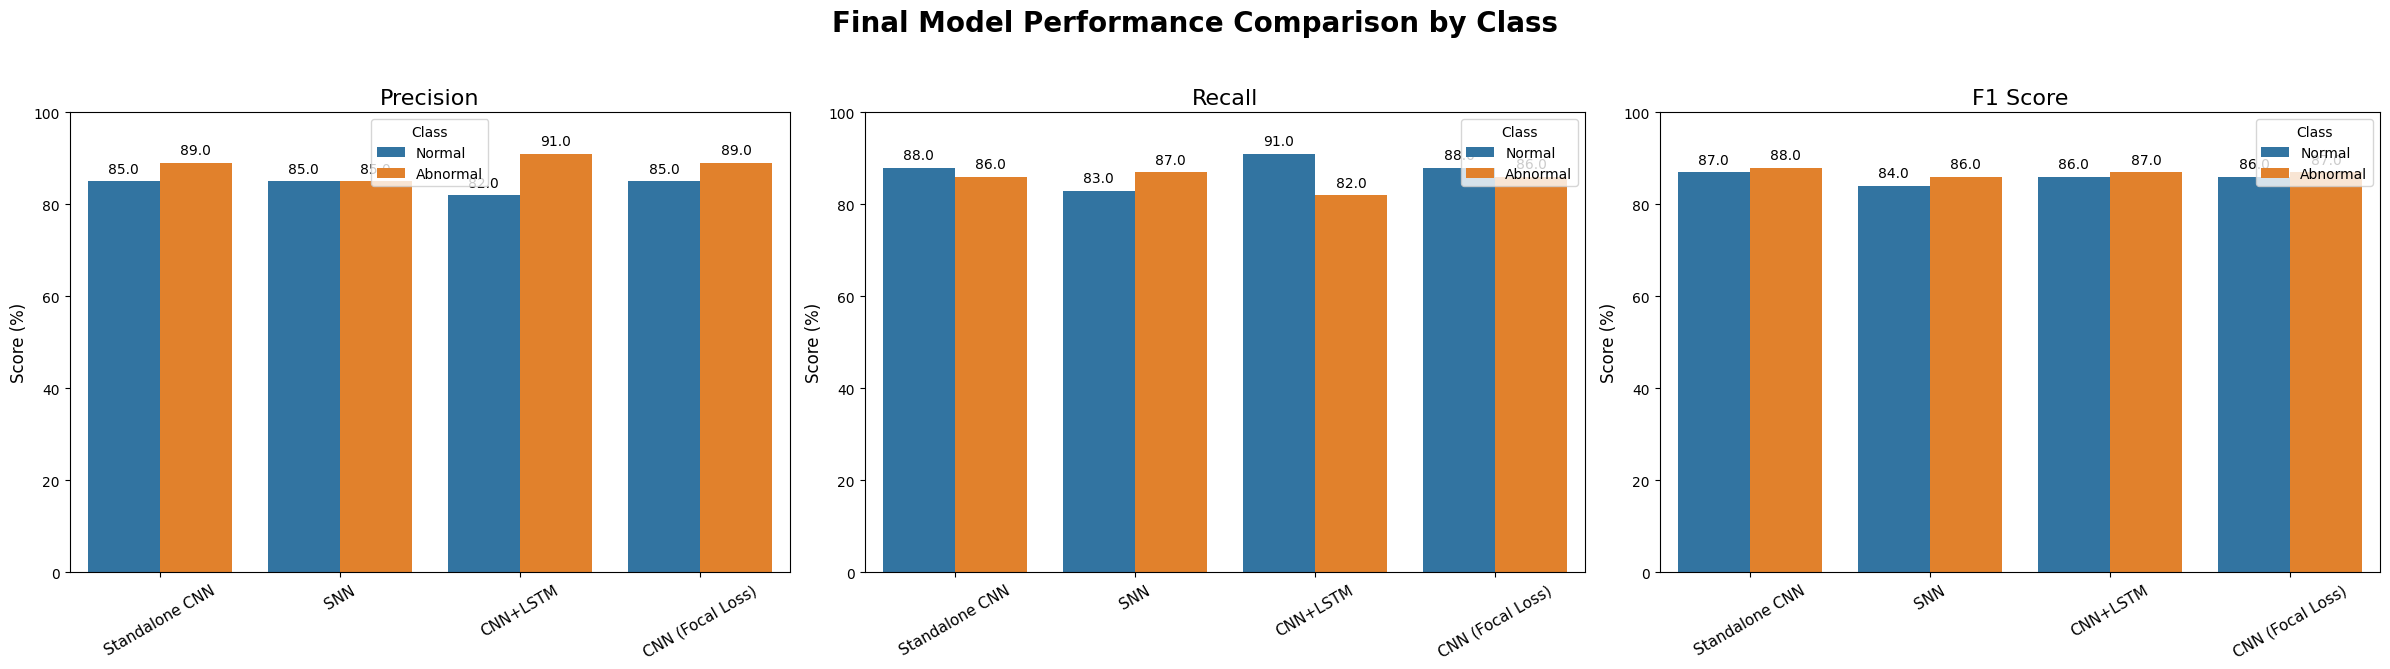

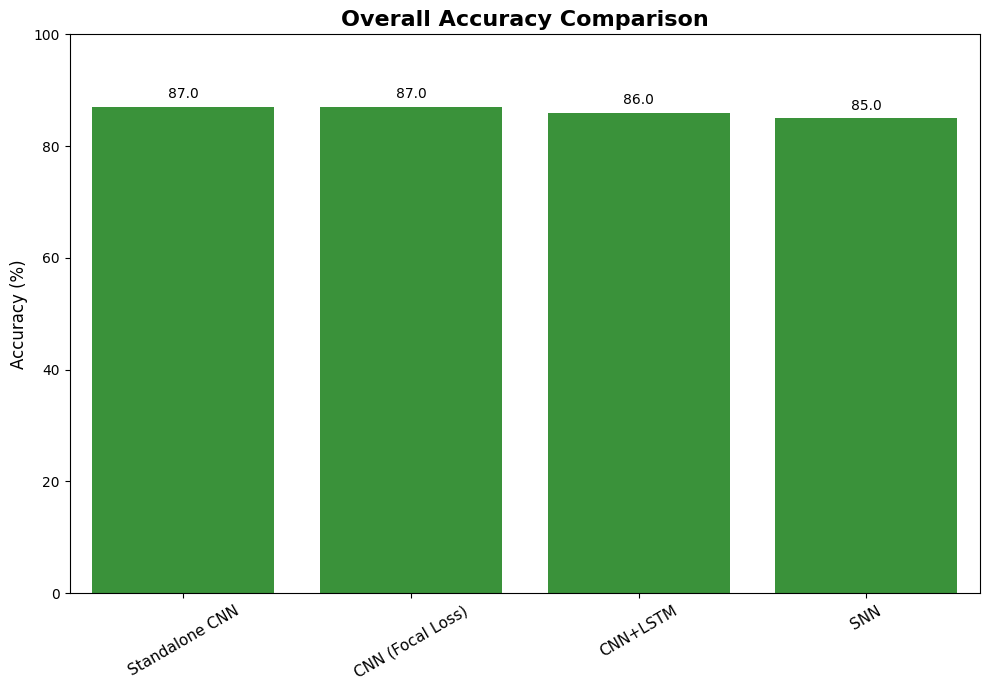

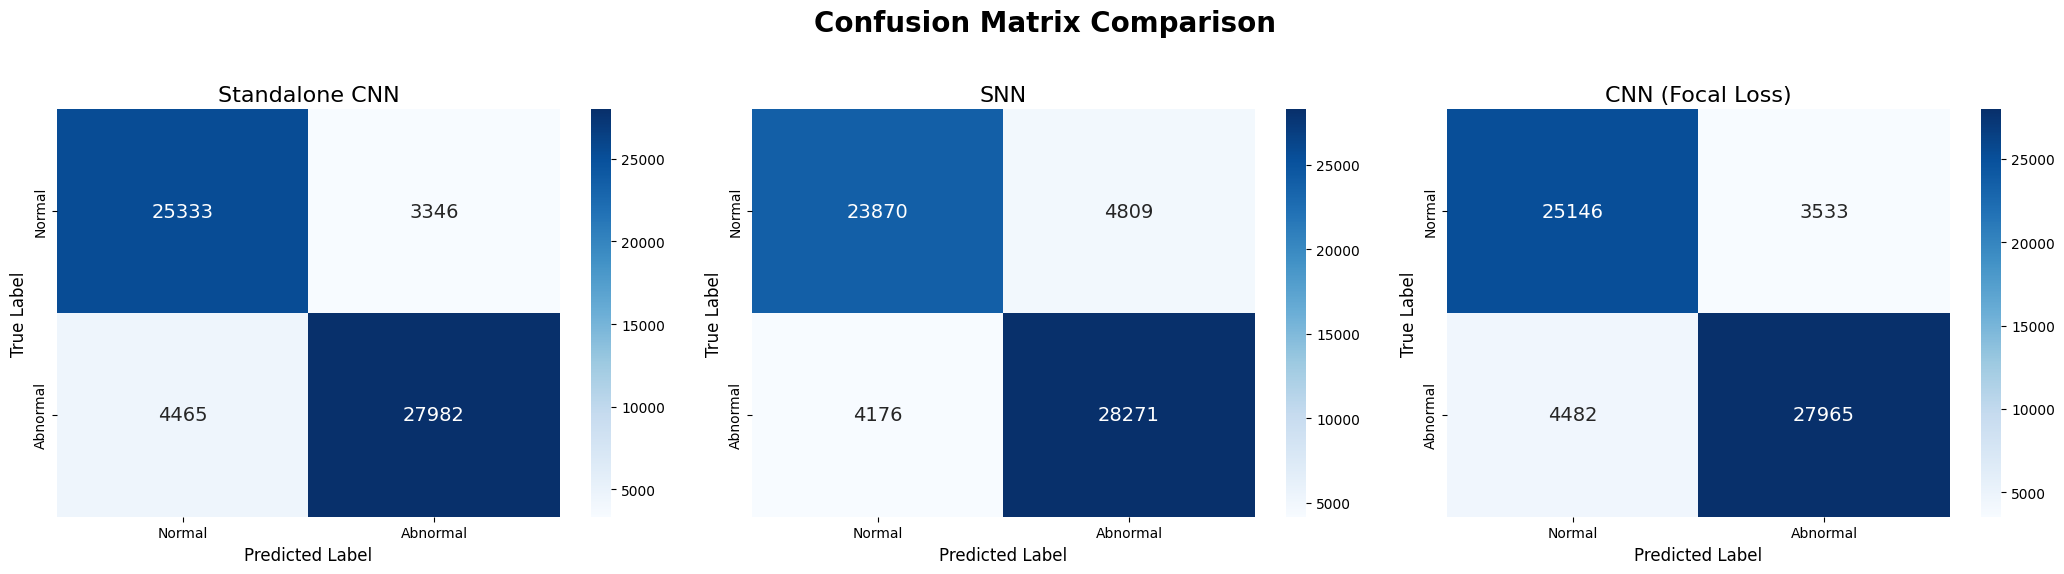

In [1]:
# --- Final Cell: Visualize and Compare All Robust Models (Definitive Version) ---

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# =============================================================================
# 1. Input the final metrics for ALL classes from your training runs
# =============================================================================
model_metrics = {
    'Standalone CNN': {
        'Normal': {'precision': 0.85, 'recall': 0.88, 'f1-score': 0.87},
        'Abnormal': {'precision': 0.89, 'recall': 0.86, 'f1-score': 0.88},
        'Overall': {'accuracy': 0.87}
    },
    'SNN': {
        'Normal': {'precision': 0.85, 'recall': 0.83, 'f1-score': 0.84},
        'Abnormal': {'precision': 0.85, 'recall': 0.87, 'f1-score': 0.86},
        'Overall': {'accuracy': 0.85}
    },
    'CNN+LSTM': {
        'Normal': {'precision': 0.82, 'recall': 0.91, 'f1-score': 0.86},
        'Abnormal': {'precision': 0.91, 'recall': 0.82, 'f1-score': 0.87},
        'Overall': {'accuracy': 0.86}
    },
    'CNN (Focal Loss)': {
        'Normal': {'precision': 0.85, 'recall': 0.88, 'f1-score': 0.86},
        'Abnormal': {'precision': 0.89, 'recall': 0.86, 'f1-score': 0.87},
        'Overall': {'accuracy': 0.87}
    }
}
confusion_matrices = {
    'Standalone CNN': np.array([[25333, 3346], [4465, 27982]]),
    'SNN': np.array([[23870, 4809], [4176, 28271]]),
    'CNN (Focal Loss)': np.array([[25146, 3533], [4482, 27965]]),
}

# =============================================================================
# 2. PLOT 1: Grouped Bar Charts for Class-wise Metric Comparison
# =============================================================================
plot_data = []
for model, classes in model_metrics.items():
    for class_name, metrics in classes.items():
        for metric, score in metrics.items():
            plot_data.append({'Model': model, 'Class': class_name, 'Metric': metric, 'Score': score * 100})
plot_df = pd.DataFrame(plot_data)

metrics_to_plot = ['precision', 'recall', 'f1-score']
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(24, 7))
fig.suptitle('Final Model Performance Comparison by Class', fontsize=20, weight='bold')

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]; metric_df = plot_df[plot_df['Metric'] == metric]
    sns.barplot(data=metric_df, x='Model', y='Score', hue='Class', ax=ax, palette={'Normal': '#1f77b4', 'Abnormal': '#ff7f0e'})
    ax.set_title(metric.replace('-', ' ').title(), fontsize=16); ax.set_ylabel("Score (%)", fontsize=12)
    ax.set_xlabel(None); ax.set_ylim(0, 100); ax.legend(title='Class')
    
    # CORRECTED LINE: Removed the 'ha' argument which caused the error
    ax.tick_params(axis='x', rotation=30, labelsize=11)

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# =============================================================================
# 3. PLOT 2: Separate Bar Chart for Overall Accuracy
# =============================================================================
accuracy_df = plot_df[plot_df['Metric'] == 'accuracy'].sort_values(by='Score', ascending=False)
plt.figure(figsize=(10, 7))
ax_acc = sns.barplot(data=accuracy_df, x='Model', y='Score', color='#2ca02c')
ax_acc.set_title('Overall Accuracy Comparison', fontsize=16, weight='bold')
ax_acc.set_ylabel("Accuracy (%)", fontsize=12); ax_acc.set_xlabel(None); ax_acc.set_ylim(0, 100)

# CORRECTED LINE: Removed the 'ha' argument which caused the error
ax_acc.tick_params(axis='x', rotation=30, labelsize=11)

for p in ax_acc.patches:
    ax_acc.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)
plt.tight_layout(); plt.show()

# =============================================================================
# 4. PLOT 3: Confusion Matrix Heatmaps
# =============================================================================
if confusion_matrices:
    num_cms = len(confusion_matrices)
    fig, axes = plt.subplots(1, num_cms, figsize=(7 * num_cms, 6))
    if num_cms == 1: axes = [axes]
    fig.suptitle('Confusion Matrix Comparison', fontsize=20, weight='bold')
    for i, (model_name, cm) in enumerate(confusion_matrices.items()):
        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'], annot_kws={"size": 14})
        ax.set_title(model_name, fontsize=16); ax.set_xlabel('Predicted Label', fontsize=12); ax.set_ylabel('True Label', fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()